In [1]:
# Imports
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
# Helper Functions
def compute_gram(X: np.ndarray) -> np.ndarray:
    """Compute Gram matrix K_ij = x_i · x_j"""
    return X @ X.T


def solve_svm_dual(X, y, C=1.0, tol=1e-5):
    """
    Solve soft-margin linear SVM (dual form) for given data X, labels y in {−1, +1}.
    Returns (lambdas, w, b, support_indices).
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)
    N = len(y)

    K = compute_gram(X)

    # Dual objective for minimization (minus the max objective)
    def dual_objective(lmbda):
        first_term = -np.sum(lmbda)
        second_term = 0.5 * np.sum(
            [lmbda[i] * lmbda[j] * y[i] * y[j] * K[i, j]
             for i in range(N) for j in range(N)]
        )
        return first_term + second_term

    # Equality constraint: sum_i lambda_i y_i = 0
    constraints = {'type': 'eq', 'fun': lambda lmbda_: np.dot(lmbda_, y)}

    # Box constraints: 0 ≤ lambda_i ≤ C
    bounds = [(0, C) for _ in range(N)]

    # Initial guess
    initial_lambda = np.zeros(N)

    sol = minimize(
        dual_objective,
        initial_lambda,
        bounds=bounds,
        constraints=constraints,
        method="SLSQP",
    )

    lmbda = sol.x

    # Indices of support vectors (non-zero lambdas)
    support = [i for i in range(N) if lmbda[i] > tol]

    # Recover primal w
    w = sum(lmbda[i] * y[i] * X[i] for i in range(N))

    # Compute bias b using support vectors
    b_candidates = [y[i] - np.dot(w, X[i]) for i in support]
    b = float(np.mean(b_candidates))

    return lmbda, w, b, support


def decision_function(X, w, b):
    X = np.asarray(X, dtype=float)
    return X @ w + b


def predict(X, w, b):
    return np.sign(decision_function(X, w, b))


In [3]:
# Toy dataset demo
# Toy customer engagement dataset
X_toy = np.array([
    [2, 6],
    [6, 2],
    [4, 6],
    [5, 3],
])

y_toy = np.array([1, -1, 1, -1])

lmbda_toy, w_star, b_star, support_idx = solve_svm_dual(X_toy, y_toy, C=1.0)

print("Optimal lambdas:", lmbda_toy)
print("Support vector indices:", support_idx)
print("w*:", w_star)
print("b*:", b_star)

# Checking margins
for xi, yi in zip(X_toy, y_toy):
    margin = yi * (np.dot(w_star, xi) + b_star)
    print(f"x={xi}, y={yi}, margin={margin:.3f}")

Optimal lambdas: [0.         0.         0.19995376 0.19995376]
Support vector indices: [2, 3]
w*: [-0.19995376  0.59986127]
b*: -1.7995837974304945
x=[2 6], y=1, margin=1.400
x=[6 2], y=-1, margin=1.800
x=[4 6], y=1, margin=1.000
x=[5 3], y=-1, margin=1.000


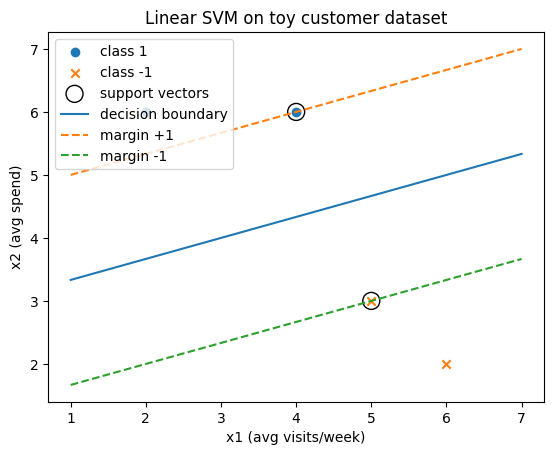

In [4]:
# Plotting decision boundary & margins
# Scatter plot of data
for yi, marker, color in [(1, "o", "C0"), (-1, "x", "C1")]:
    idx = (y_toy == yi)
    plt.scatter(X_toy[idx, 0], X_toy[idx, 1], marker=marker, label=f"class {yi}")

# Highlight support vectors
plt.scatter(
    X_toy[support_idx, 0], X_toy[support_idx, 1],
    s=150, facecolors="none", edgecolors="k", label="support vectors"
)

# Decision boundary: w1 x1 + w2 x2 + b = 0
x1_vals = np.linspace(1, 7, 100)
x2_vals = -(w_star[0] * x1_vals + b_star) / w_star[1]
plt.plot(x1_vals, x2_vals, label="decision boundary")

# Margins: w·x + b = +/- 1
margin = 1.0
x2_margin_pos = -(w_star[0] * x1_vals + b_star - margin) / w_star[1]
x2_margin_neg = -(w_star[0] * x1_vals + b_star + margin) / w_star[1]
plt.plot(x1_vals, x2_margin_pos, "--", label="margin +1")
plt.plot(x1_vals, x2_margin_neg, "--", label="margin -1")

plt.xlabel("x1 (avg visits/week)")
plt.ylabel("x2 (avg spend)")
plt.title("Linear SVM on toy customer dataset")
plt.legend()
plt.show()